In [1]:
import sys
import os

# # Simple approach: add the parent directory to Python path
# project_root = os.path.dirname(os.getcwd())
# sys.path.insert(0, project_root)
# print(f"Added {project_root} to Python path")
# print(f"Current working directory: {os.getcwd()}")

import pickle
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [2]:
final_result = np.load('u_v1_v2_filling_1p5_t_4_em4_random_basis_mesh_60_gpu_scaling.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
v1_arr = u_arr
u_mesh, v1_mesh = np.meshgrid(u_arr, v1_arr, indexing = 'ij')

In [3]:
np.max(final_c_difference)

np.float64(9.999939831750737e-08)

In [4]:
np.max(final_e_difference)

np.float64(9.999052474896075e-09)

### Phase Analysis

In [5]:
from functions_parameters.tools import rot_symm_m_check_d
from functions_parameters.universal_parameters import pauli_matrices

c_6 = np.array([[0,0,1],
               [1,0,0],
               [0,1,0]])
c_3 = c_6@c_6
c_2 = c_6 @ c_3

In [6]:
nematic_phase = ['R symmetric', 'C3 charge nematic', 'C2 charge nematic', 'no R']
Magnetism_phase = [' +', ' FM', ' AFM']

phase_list_final = list(i+j for i,j in product(nematic_phase, Magnetism_phase))

In [7]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)

In [8]:
threshold = 1E-5

phase_diagram_based_on_d = np.zeros(u_mesh.shape)
gs_m = np.zeros(u_mesh.shape)
gs_n = np.zeros(u_mesh.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording = np.zeros((4))
        m_recording = np.zeros((3))
        c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_o, c_6, c_3, c_2)
        gs_n[i,j] = c6_diff
        if c6_diff<threshold:
            rs_recording[0] = 1
        elif c6_diff>threshold and c3_diff<threshold:
            rs_recording[1] = 1
        elif c2_diff<threshold and c6_diff>threshold:
            rs_recording[2] = 1
        # else:
        #     rs_recording[3] = 1
        gs_m[i,j] = np.max(np.abs(magnetism_arr))
        if np.max(np.abs(magnetism_arr))>threshold:
            sign = np.sign(np.sum(np.sign(magnetism_arr)))
            offsetted_magnetism_arr = magnetism_arr - sign*threshold
            if np.min(offsetted_magnetism_arr)*sign>0:
                m_recording[1] = 1
            else:
                m_recording[2] = 1
        else:
            m_recording[0] = 1
        phase_arr = np.kron(rs_recording,m_recording)
        phase = np.where(phase_arr>0.5)[0][0]
        # it this right???????
        phase_diagram_based_on_d[i,j]=phase

Text(0.5, 1.0, 'filling = 1')

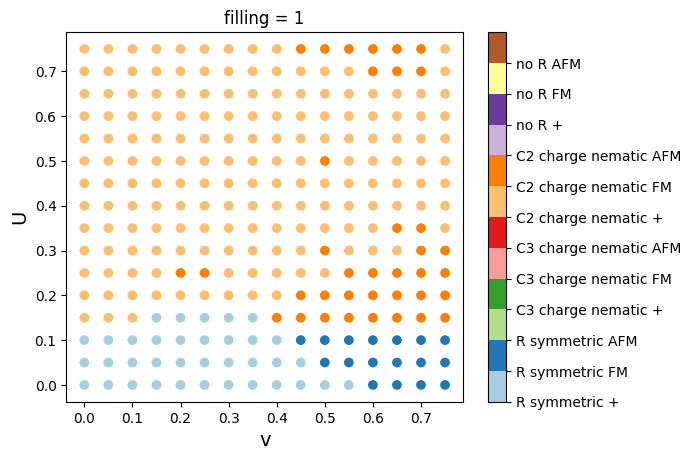

In [9]:
colorbar_ticks_combined = np.arange(len(phase_list_final))
cmap = plt.get_cmap("Paired", len(phase_list_final))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(u_mesh, v1_mesh, c=phase_diagram_based_on_d, cmap=cmap,vmin=0, vmax=len(phase_list_final))
# plt.xlabel(r'$E_{f}$', size = '14')
plt.xlabel('v', size = '14')
plt.ylabel('U', size = '14')
# plt.xlim(3.8,6)
colorbar_ticks = np.arange(len(phase_list_final))
cbar = plt.colorbar()
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels(phase_list_final)
plt.title('filling = 1')

In [10]:
unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_list_final[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'filling = 1')

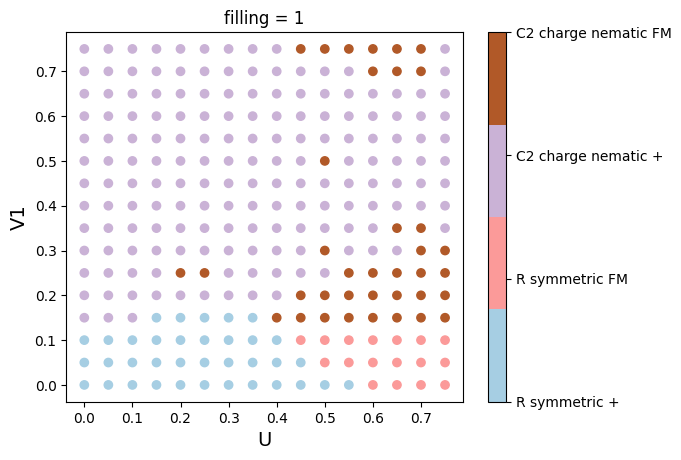

In [11]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(u_mesh, v1_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('U', size = '14')
plt.ylabel('V1', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

Text(0.5, 1.0, 'filling = 1')

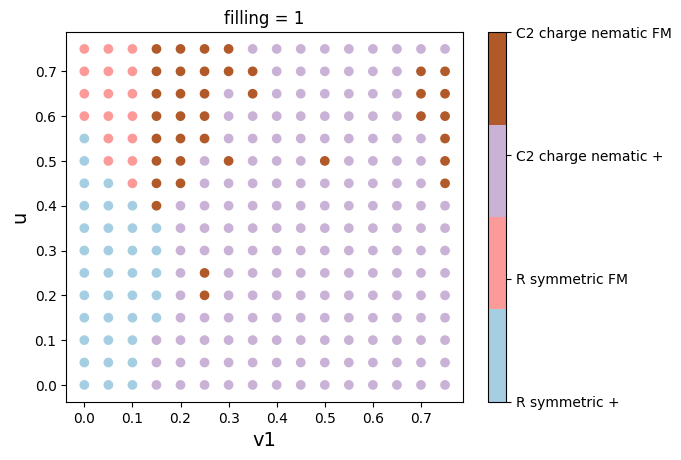

In [12]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(v1_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

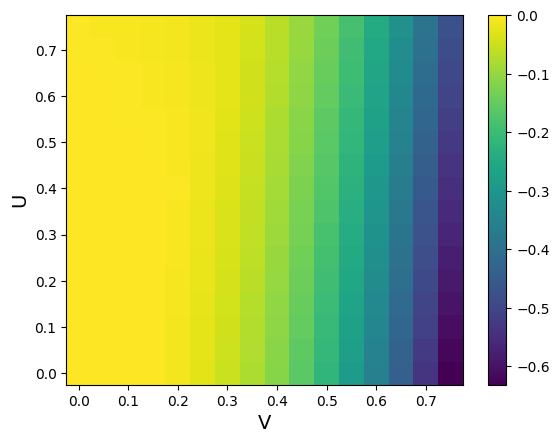

In [13]:
plt.pcolormesh(v1_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

Text(0.5, 1.0, 'ground state c_6_diff')

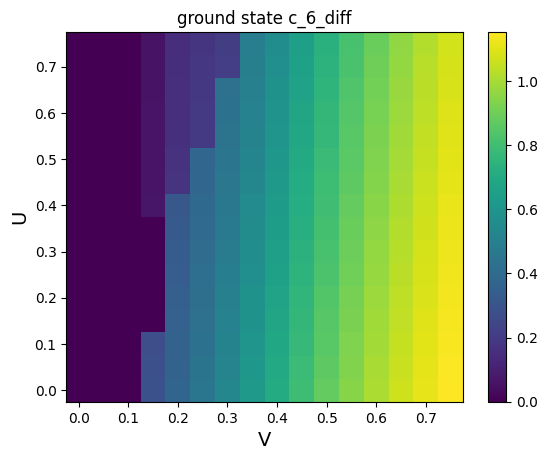

In [14]:
plt.pcolormesh(v1_mesh,u_mesh,gs_n)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state c_6_diff')

Text(0.5, 1.0, 'ground state max magnetization')

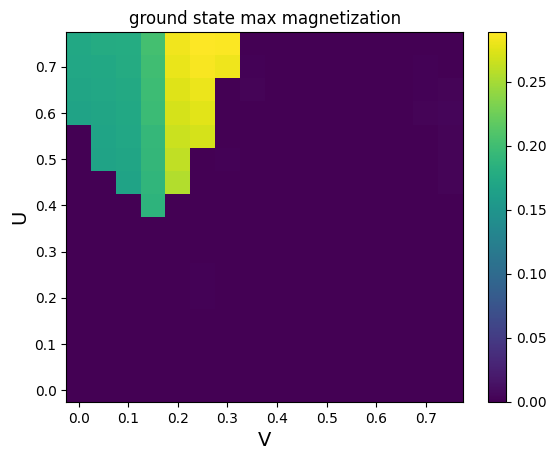

In [15]:
plt.pcolormesh(v1_mesh,u_mesh,gs_m)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state max magnetization')

In [16]:
sorted_density[5,5,5]

array([[0.38731845+2.84302930e-25j, 0.1813406 +9.46269665e-20j,
        0.18134095+1.57745158e-20j],
       [0.38731845+2.84302930e-25j, 0.1813406 +9.46269665e-20j,
        0.18134095+1.57745158e-20j]])

In [17]:
sorted_ground_state_e[5,5]

array([-0.02025895, -0.02025895, -0.02025895, -0.02025895, -0.02025895,
       -0.02025722, -0.02025722, -0.02025722, -0.01017413,  0.00739038])

In [18]:
sorted_ground_state_e[4,5]

array([-0.02169421, -0.02169421, -0.02169421, -0.02169421, -0.02169421,
       -0.02169421, -0.02169283, -0.02169283, -0.02169283,  0.00856698])

In [19]:
sorted_density[4,5,0]

array([[0.38983494+2.80664456e-25j, 0.18132716+2.01961588e-20j,
        0.18132723-9.51288999e-20j],
       [0.38877427+1.56776301e-25j, 0.17936818-3.30829886e-20j,
        0.17936822-4.21641821e-20j]])

In [20]:
sorted_density[4,5,6]

array([[0.18035095-2.68785802e-23j, 0.18035105-6.00860255e-20j,
        0.389298  +1.21581638e-19j],
       [0.18035095-2.68785802e-23j, 0.18035105-6.00860255e-20j,
        0.389298  +1.21581638e-19j]])

In [21]:
sorted_ground_state_e_index[4,5]

array([4, 5, 6, 8, 7, 9, 2, 1, 3, 0])

In [22]:
final_bond[4,5,2]

array([[[[[ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
           -0.        +0.00000000e+00j],
          [ 0.        -0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        -0.00000000e+00j],
          [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j]],

         [[ 0.        +0.00000000e+00j,  0.08585256-5.62014444e-17j,
           -0.        +0.00000000e+00j],
          [ 0.        -0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        -0.00000000e+00j],
          [ 0.        +0.00000000e+00j,  0.08727433+1.77153348e-16j,
            0.        +0.00000000e+00j]]],


        [[[ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
           -0.        +0.00000000e+00j],
          [ 0.        -0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        -0.00000000e+00j],
          [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j]],

  

In [23]:
final_bond[4,5,4]

array([[[[[ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j],
          [ 0.        -0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        -0.00000000e+00j],
          [-0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j]],

         [[ 0.        +0.00000000e+00j,  0.08783815+1.28092013e-17j,
            0.        +0.00000000e+00j],
          [ 0.        -0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        -0.00000000e+00j],
          [-0.        +0.00000000e+00j,  0.08670403-1.85094722e-18j,
            0.        +0.00000000e+00j]]],


        [[[ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j],
          [ 0.        -0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        -0.00000000e+00j],
          [ 0.        -0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j]],

  

In [24]:
la.norm(np.abs(final_bond[4,5,4] - final_bond[4,5,2])) 

np.float64(0.6325952198494829)

In [25]:
sorted_density[6,5,0]

array([[0.38463532-2.04354832e-25j, 0.18268217+3.84276960e-21j,
        0.18268251-3.20211605e-20j],
       [0.38463532-2.04354832e-25j, 0.18268217+3.84276960e-21j,
        0.18268251-3.20211605e-20j]])

In [26]:
sorted_ground_state_e[-2,-1]

array([-0.48583096, -0.48583096, -0.48583096, -0.48583096, -0.48583096,
       -0.48583096, -0.4858308 , -0.4858308 , -0.48583079, -0.09179345])

In [27]:
sorted_density[-2,-1,0]

array([[0.07020998+1.87189561e-26j, 0.07020998+4.70952279e-20j,
        0.61010768+1.57964782e-19j],
       [0.07011147+4.65578619e-26j, 0.07011147+1.55619756e-20j,
        0.60924943+7.76743089e-20j]])

In [28]:
sorted_density[-2,-1,6]

array([[0.07016122+6.84172034e-25j, 0.07016133-1.04450164e-20j,
        0.60967745+3.99785016e-20j],
       [0.07016122+6.84172034e-25j, 0.07016133-1.04450164e-20j,
        0.60967745+3.99785016e-20j]])

In [29]:
np.mean(final_iteration)

np.float64(37.3171875)

In [30]:
np.max(final_iteration)

np.int32(383)

In [31]:
np.min(final_iteration)

np.int32(2)

### Test the degeneracy of energy